In [85]:
!pip install yfinance

In [86]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
  Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [87]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt

# 0) Dataset for Modeling: Final Preparations

## 0.1) Importing data from Drive & defining variable sets
* automated version need to have a daily updated file/database entries

In [88]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/




Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=2231c865-0f23-45f1-bba5-f25e3fa8dbb0
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:01<00:00, 62.6MB/s]


In [89]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )


In [90]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [91]:
df_full.keys()

Index(['Open', 'High', 'Low', 'Close', 'Adj Close_x', 'Volume', 'Ticker',
       'Year', 'Month', 'Weekday',
       ...
       'growth_brent_oil_7d', 'growth_brent_oil_30d', 'growth_brent_oil_90d',
       'growth_brent_oil_365d', 'growth_btc_usd_1d', 'growth_btc_usd_3d',
       'growth_btc_usd_7d', 'growth_btc_usd_30d', 'growth_btc_usd_90d',
       'growth_btc_usd_365d'],
      dtype='object', length=202)

In [92]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [93]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [94]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [95]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [96]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [97]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

In [98]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [99]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [100]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')


Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [101]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [102]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [103]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP]
OTHER

['growth_future_5d', 'is_positive_growth_5d_future']

In [104]:
df_full.Ticker.nunique()

33

In [105]:
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2024-05-07,10941
ACN,2001-07-19,2024-05-07,5736
AMZN,1997-05-15,2024-05-07,6789
ASML,1995-03-15,2024-05-07,7338
AVGO,2009-08-06,2024-05-07,3713
BHARTIARTL.NS,2002-07-01,2024-05-07,5424
BRK-B,1996-05-09,2024-05-07,7046
CDI.PA,1992-01-27,2024-05-07,8328
GOOG,2004-08-19,2024-05-07,4963


In [106]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


In [107]:
# let look at the features count and size:
df[NUMERICAL].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


## 0.2) [Code snippet 1] Generating dummies

In [108]:
# what are the categorical features?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [109]:
# dummy variables are not generated from Date and numeric variables
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

In [110]:
# TODO 1: define more categorical features, e.g. all combinations for <September+weekday>  (you'll see that September is actually an important dummy in one of the models)

df['wom'] = df.Date.apply(lambda d: (d.day-1) // 7 + 1)
df.loc[:,'wom'] = df.wom.astype(str)
df['month_wom'] = df.Month + '_w' + df.wom
df[['Date','month_wom']].tail(100)

<ipython-input-110-f1307215c357>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-110-f1307215c357>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,month_wom
5327,2023-12-07,December_w1
5328,2023-12-08,December_w2
5329,2023-12-11,December_w2
5330,2023-12-12,December_w2
5331,2023-12-13,December_w2
...,...,...
5422,2024-04-30,April_w5
5423,2024-05-02,May_w1
5424,2024-05-03,May_w1
5425,2024-05-06,May_w1


In [111]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [112]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [113]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 81.5 MB


In [114]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
print(DUMMIES)

['Month_April', 'Month_August', 'Month_December', 'Month_February', 'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May', 'Month_November', 'Month_October', 'Month_September', 'Weekday_0', 'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5', 'Weekday_6', 'Ticker_AAPL', 'Ticker_ACN', 'Ticker_AMZN', 'Ticker_ASML', 'Ticker_AVGO', 'Ticker_BHARTIARTL.NS', 'Ticker_BRK-B', 'Ticker_CDI.PA', 'Ticker_GOOG', 'Ticker_HDB', 'Ticker_HINDUNILVR.NS', 'Ticker_IBN', 'Ticker_IDEXY', 'Ticker_INFY', 'Ticker_ITC.NS', 'Ticker_JPM', 'Ticker_LICI.NS', 'Ticker_LLY', 'Ticker_LT.NS', 'Ticker_MC.PA', 'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_NVO', 'Ticker_OR.PA', 'Ticker_RELIANCE.NS', 'Ticker_RMS.PA', 'Ticker_SAP', 'Ticker_SBIN.NS', 'Ticker_SIE.DE', 'Ticker_TCS.NS', 'Ticker_TTE', 'Ticker_V', 'ticker_type_EU', 'ticker_type_INDIA', 'ticker_type_US', 'month_wom_April_w1', 'month_wom_April_w2', 'month_wom_April_w3', 'month_wom_April_w4', 'month_wom_April_w5', 'month_wom_August

In [115]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [116]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


In [117]:
df_with_dummies[['Date','month_wom', 'month_wom_December_w1', 'month_wom_December_w2', 'month_wom_April_w4', 'month_wom_April_w5', 'month_wom_May_w1', 'month_wom_May_w2']].tail(100)

,Date,month_wom,month_wom_December_w1,month_wom_December_w2,month_wom_April_w4,month_wom_April_w5,month_wom_May_w1,month_wom_May_w2
5327,2023-12-07,December_w1,1,0,0,0,0,0
5328,2023-12-08,December_w2,0,1,0,0,0,0
5329,2023-12-11,December_w2,0,1,0,0,0,0
5330,2023-12-12,December_w2,0,1,0,0,0,0
5331,2023-12-13,December_w2,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
5422,2024-04-30,April_w5,0,0,0,1,0,0
5423,2024-05-02,May_w1,0,0,0,0,1,0
5424,2024-05-03,May_w1,0,0,0,0,1,0
5425,2024-05-06,May_w1,0,0,0,0,1,0


## 0.3) [Code Snippet 2] Correlation analysis
* first approximation of "important" variables correlated with all variables we want to predict (TO_PREDICT)

In [118]:
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [119]:
corr_is_positive_growth_5d_future = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['is_positive_growth_5d_future']

In [120]:
# create a dataframe for an easy way to sort
corr_is_positive_growth_5d_future_df = pd.DataFrame(corr_is_positive_growth_5d_future)

In [121]:
list_df_with_dummies_keys = df_with_dummies.keys().to_list()
len(list_df_with_dummies_keys)

320

In [122]:
#remove all but the dummies
#corr_is_positive_growth_5d_future_df
DUMMIES_TO_KEEP = [g for g in df_with_dummies.keys() if g.find('month_wom_')>=0]
len(DUMMIES_TO_KEEP)

60

In [123]:
DUMMIES_TO_DROP = [g for g in list_df_with_dummies_keys if g not in DUMMIES_TO_KEEP]
len(DUMMIES_TO_DROP)

260

In [124]:
# prompt: drop all rows from corr_is_positive_growth_5d_future_df not starting with month_wom_

corr_is_positive_growth_5d_future_df = corr_is_positive_growth_5d_future_df[corr_is_positive_growth_5d_future_df.index.str.startswith('month_wom_')]
corr_is_positive_growth_5d_future_df

,is_positive_growth_5d_future
month_wom_April_w1,-0.004023
month_wom_April_w2,-0.000227
month_wom_April_w3,0.009226
month_wom_April_w4,-0.001560
month_wom_April_w5,-0.008793
month_wom_August_w1,-0.011796
month_wom_August_w2,-0.010177
month_wom_August_w3,-0.005565
month_wom_August_w4,0.006878
month_wom_August_w5,0.002611


In [125]:
# prompt: sort corr_is_positive_growth_5d_future_df by the absolute value of is_positive_growth_5d_future

corr_is_positive_growth_5d_future_df = corr_is_positive_growth_5d_future_df.sort_values(by=['is_positive_growth_5d_future'], key=abs, ascending=False)
corr_is_positive_growth_5d_future_df

,is_positive_growth_5d_future
month_wom_September_w3,-0.034537
month_wom_March_w4,0.026058
month_wom_October_w5,0.026023
month_wom_February_w3,-0.024578
month_wom_May_w4,0.022264
month_wom_May_w1,-0.022040
month_wom_June_w3,-0.019754
month_wom_December_w4,0.019270
month_wom_December_w3,0.018295
month_wom_June_w1,-0.017471


In [126]:
# prompt: get max absolute value of is_positive_growth_5d_future in corr_is_positive_growth_5d_future_df and round to 3 decimal places

corr_is_positive_growth_5d_future_df['is_positive_growth_5d_future'].abs().max().round(3)


0.035

# HA3 Q1
Answer: 0.035

In [127]:
corr_is_positive_growth_5d_future_df.sort_values(by='is_positive_growth_5d_future').head(5)

,is_positive_growth_5d_future
month_wom_September_w3,-0.034537
month_wom_February_w3,-0.024578
month_wom_May_w1,-0.022040
month_wom_June_w3,-0.019754
month_wom_June_w1,-0.017471


In [128]:
corr_is_positive_growth_5d_future_df.sort_values(by='is_positive_growth_5d_future').tail(8)

,is_positive_growth_5d_future
month_wom_October_w2,0.013996
month_wom_November_w4,0.014794
month_wom_October_w4,0.016331
month_wom_December_w3,0.018295
month_wom_December_w4,0.019270
month_wom_May_w4,0.022264
month_wom_October_w5,0.026023
month_wom_March_w4,0.026058


In [129]:
corr_growth_future_5d = df_with_dummies[NUMERICAL+DUMMIES+TO_PREDICT].corr()['growth_future_5d']

In [130]:
corr_growth_future_5d_df = pd.DataFrame(corr_growth_future_5d)

In [131]:
corr_growth_future_5d_df.sort_values(by='growth_future_5d').head(5)

,growth_future_5d
growth_7d,-0.050680
growth_3d,-0.049925
growth_brent_oil_365d,-0.041784
roc,-0.040579
rocr,-0.040579


In [132]:
corr_growth_future_5d_df.sort_values(by='growth_future_5d').tail(8)

,growth_future_5d
growth_btc_usd_3d,0.032382
natr,0.036051
growth_btc_usd_7d,0.036124
is_positive_growth_5d_future,0.668535
growth_future_5d,1.000000
cdl3starsinsouth,NaN
cdlconcealbabyswall,NaN
cdlmathold,NaN


## 0.4) [Code snippet 3] Temporal split of ~25 years of data (by date)

In [133]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.6).
        val_prop (float): Proportion of data for validation set (default: 0.2).
        test_prop (float): Proportion of data for test set (default: 0.2).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [134]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [135]:
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [136]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

# 1) Modeling: "rule of thumb" or hand-predictions

In [137]:
# let's have a time-series or one ticker
df_nvda = new_df[new_df.Ticker=='NVDA']

In [138]:
fig = px.line(df_nvda, x="Date", y="Adj Close_x", title='NVDA price')
fig.show()

In [139]:
# TRAIN / VALIDATION/ TEST split

# Calculate the lengths of each split -- this is not temporal split, but based on the number of observations --> "classic" split with no shuffle
total_length = len(df_nvda)
train_length = int(0.8 * total_length)
val_length = int(0.1 * total_length)

# Split the data
train_data = df_nvda.iloc[:train_length]
val_data = df_nvda.iloc[train_length:train_length+val_length]
test_data = df_nvda.iloc[train_length+val_length:]

# Plot the data
fig = px.line(title='NVDA Adj.Close price daily for three time intervals Train/Validation/Test')
fig.add_scatter(x=train_data['Date'], y=train_data['Adj Close_x'], mode='lines', name='Train', line=dict(color='blue'))
fig.add_scatter(x=val_data['Date'], y=val_data['Adj Close_x'], mode='lines', name='Validation', line=dict(color='orange'))
fig.add_scatter(x=test_data['Date'], y=test_data['Adj Close_x'], mode='lines', name='Test', line=dict(color='green'))

# Update layout to center the title
fig.update_layout(title=dict(x=0.5))

fig.show()

In [140]:
# HIST ON NVDA DATA Train/Test/Validation
import plotly.graph_objects as go

# Plot the data
fig = go.Figure()

# Add histograms for each split
fig.add_trace(go.Histogram(x=train_data['growth_future_5d'], name='Train', opacity=0.75))
fig.add_trace(go.Histogram(x=val_data['growth_future_5d'], name='Validation', opacity=0.75))
fig.add_trace(go.Histogram(x=test_data['growth_future_5d'], name='Test', opacity=0.75))

fig.update_layout(barmode='overlay', title='Distribution of growth_future_5d for NVIDIA (NVDA) Growth by Train/Valid/Test sets')
fig.update_traces(opacity=0.75)

fig.show()


In [141]:
# HIST ON ALL DATA Train/Test/Validation
# comment: there are some outliers and hard co compare the distributions
import plotly.graph_objects as go

# Plot the data
fig = go.Figure()

# Add histograms for each split
fig.add_trace(go.Histogram(x=df_with_dummies[df_with_dummies.split=='train']['growth_future_5d'], name='Train', opacity=0.75))
fig.add_trace(go.Histogram(x=df_with_dummies[df_with_dummies.split=='validation']['growth_future_5d'], name='Validation', opacity=0.75))
fig.add_trace(go.Histogram(x=df_with_dummies[df_with_dummies.split=='test']['growth_future_5d'], name='Test', opacity=0.75))

fig.update_layout(barmode='overlay', title='Distribution of growth_future_5d for All tickers Growth by Train/Valid/Test sets')
fig.update_traces(opacity=0.75)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [142]:
# Assuming df_with_dummies is your DataFrame containing the 'growth_future_5d' variable and 'split' column

# Create the histogram
fig = px.histogram(new_df,
                   x="growth_future_5d",
                   color="split",
                   marginal="box", # or violin, rug
                   )
                  #  hover_data=new_df.growth_future_5d)

# Show the histogram
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [143]:
new_df.groupby(by='split')['growth_future_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,29664.0,1.005015,0.040835,0.690219,0.981994,1.004731,1.027028,1.393477
train,123458.0,1.003965,0.053826,0.412383,0.978474,1.003197,1.028354,3.018887
validation,29388.0,1.004417,0.040642,0.668581,0.985343,1.005120,1.023999,1.459217


In [144]:
# is_positive_growth_5d_future: ONLY NVDA stock

# Count occurrences of 0 and 1 for each split
train_counts = train_data['is_positive_growth_5d_future'].value_counts(normalize=True)*100
val_counts = val_data['is_positive_growth_5d_future'].value_counts(normalize=True)*100
test_counts = test_data['is_positive_growth_5d_future'].value_counts(normalize=True)*100

# Plot the data
fig = go.Figure()

# # Add stacked bar charts for each split
# fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[0], val_counts[0], test_counts[0]], name='0'))
# fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[1], val_counts[1], test_counts[1]], name='1'))


# Add stacked bar charts for each split
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[0], val_counts[0], test_counts[0]], name='0',
                     text=[f'{count:.2f}%' for count in [train_counts[0], val_counts[0], test_counts[0]]], textposition='auto'))
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[1], val_counts[1], test_counts[1]], name='1',
                     text=[f'{count:.2f}%' for count in [train_counts[1], val_counts[1], test_counts[1]]], textposition='auto'))


fig.update_layout(barmode='stack', title='Distribution of is_positive_growth_5d_future by Train/Validation/Test for NVDA stock')
fig.update_traces(opacity=0.75)

fig.show()

In [145]:
# ALL STOCKS: train/test/validation is more similar

# Count occurrences of 0 and 1 for each split
train_counts = df_with_dummies[df_with_dummies.split=='train']['is_positive_growth_5d_future'].value_counts(normalize=True)*100
val_counts = df_with_dummies[df_with_dummies.split=='validation']['is_positive_growth_5d_future'].value_counts(normalize=True)*100
test_counts = df_with_dummies[df_with_dummies.split=='test']['is_positive_growth_5d_future'].value_counts(normalize=True)*100

# Plot the data
fig = go.Figure()


# Add stacked bar charts for each split
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[0], val_counts[0], test_counts[0]], name='0',
                     text=[f'{count:.2f}%' for count in [train_counts[0], val_counts[0], test_counts[0]]], textposition='auto'))
fig.add_trace(go.Bar(x=['Train', 'Validation', 'Test'], y=[train_counts[1], val_counts[1], test_counts[1]], name='1',
                     text=[f'{count:.2f}%' for count in [train_counts[1], val_counts[1], test_counts[1]]], textposition='auto'))


fig.update_layout(barmode='stack', title='Distribution of is_positive_growth_5d_future by Train/Validation/Test for ALL stocks')
fig.update_traces(opacity=0.75)

fig.show()

# 1) Modeling: "rule of thumb" or hand-predictions

## 1.1) Review all the inputs again

In [146]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [147]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 321 entries, Open to split
dtypes: datetime64[ns](2), float64(129), int32(178), int64(5), object(7)
memory usage: 324.7+ MB


In [148]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
3490,58.6875,59.3125,56.0,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,0,train


In [149]:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,min,max,count
split,,,
test,2020-09-14,2024-05-07,29829
train,2000-01-03,2017-01-16,123458
validation,2017-01-17,2020-09-11,29388


In [150]:
# what we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_5d,is_positive_growth_5d_future
3490,0.963003,0


In [151]:
# to be used as features
new_df[NUMERICAL+DUMMIES].head(1)

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,month_wom_October_w1,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5
3490,0.998394,0.988341,0.991494,1.372333,1.222951,2.063053,0.970196,0.983855,1.051736,1.134572,...,0,0,0,0,0,0,0,0,0,0


## 1.2) [Code Snippet 3] Manual "hand rule" predictions
* CCI (binary, on technical indicator CCI)
* growth_1d>0
* growth_1d>0 & growth_snp500_1d>0

In [152]:
# why does it work?
# compare a vector (pandas.core.series.Series) with scalar 200 ==> element_wise comparison with the number
new_df.cci>200

3490    False
3491    False
3492    False
3493    False
3494    False
        ...  
5422    False
5423    False
5424    False
5425    False
5426    False
Name: cci, Length: 182675, dtype: bool

In [153]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)

In [154]:
# TODO 2: find more "hand rules" - can get it from decision trees important factors, or randomly build on other most popular macro/tech indicators/ manual_features
new_df['pred3_manual_gdp_fastd'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >= 0.251)).astype(int)
new_df['pred4_manual_gdp_wti_oil'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [155]:
new_df[['cci','growth_1d','growth_snp500_1d','gdppot_us_yoy','fastd', 'growth_wti_oil_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_gdp_fastd', 'pred4_manual_gdp_wti_oil','is_positive_growth_5d_future']]

,cci,growth_1d,growth_snp500_1d,gdppot_us_yoy,fastd,growth_wti_oil_30d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_fastd,pred4_manual_gdp_wti_oil,is_positive_growth_5d_future
3490,26.847237,0.998394,0.990451,0.044886,37.739340,NaN,0,0,0,0,0,0
3491,-34.319663,0.966220,0.961655,0.044886,27.249258,NaN,0,0,0,0,0,0
3492,-97.318008,1.010544,1.001922,0.044886,35.788722,NaN,0,1,1,0,0,0
3493,-169.947507,0.966502,1.000956,0.044886,21.913170,NaN,0,0,0,0,0,0
3494,-142.142685,1.013068,1.027090,0.044886,31.443194,NaN,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5422,-29.424989,0.988994,0.984269,0.022151,41.583773,0.990450,0,0,0,1,0,0
5423,-26.657181,1.001447,1.009128,0.022151,33.147297,0.966577,0,1,1,1,0,0
5424,-123.785473,0.972302,1.012557,0.022151,15.053103,0.963488,0,0,0,1,0,0
5425,-181.986224,0.989571,1.010326,0.022151,14.427949,0.973335,0,0,0,1,0,0


In [156]:
# prompt: show me where pred4_manual_gdp_wti_oil equals 1

new_df[new_df['pred4_manual_gdp_wti_oil'] == 1]


,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_fastd,pred4_manual_gdp_wti_oil
3682,27.750000,28.625000,27.625000,27.687500,17.133570,81099400.0,MSFT,2000,October,3,...,0,0,0,0,train,0,0,0,0,1
3683,27.906250,28.375000,27.375000,27.781250,17.191576,61794000.0,MSFT,2000,October,4,...,0,0,0,0,train,0,1,0,0,1
3684,27.812500,27.875000,26.500000,27.093750,16.766140,58323600.0,MSFT,2000,October,0,...,0,0,0,0,train,0,0,0,0,1
3689,26.750000,26.906250,24.781250,25.187500,15.586514,119759000.0,MSFT,2000,October,0,...,0,0,0,0,train,0,0,0,0,1
3690,25.937500,26.218750,25.125000,25.218750,15.605855,81276600.0,MSFT,2000,October,1,...,0,0,0,0,train,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,40.688889,40.755554,40.022221,40.080002,30.618311,1910772.0,LT.NS,2002,July,2,...,0,0,0,0,train,0,0,0,0,1
5,40.644444,40.866665,40.000000,40.791111,31.161547,1772149.0,LT.NS,2002,July,0,...,0,0,0,0,train,0,1,0,0,1
6,40.888889,41.222221,40.502220,40.613335,31.025751,2892991.0,LT.NS,2002,July,1,...,0,0,0,0,train,0,0,0,0,1
27,36.644444,36.644444,36.266666,36.355556,27.773102,884349.0,LT.NS,2002,August,2,...,0,0,0,0,train,0,1,1,0,1


In [157]:
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_fastd',
 'pred4_manual_gdp_wti_oil']

In [158]:
p = PREDICTIONS[0]
part1 = p.split('_')[0] # first prefix before '_'
print(f'Full column name: {p}, only first part: {part1}')

Full column name: pred0_manual_cci, only first part: pred0


In [159]:
# One prediction: do we predict correctly?
new_df['is_correct_prediction'] = (new_df.pred0_manual_cci == new_df.is_positive_growth_5d_future)

In [160]:
new_df[['cci','pred0_manual_cci','is_positive_growth_5d_future','is_correct_prediction']]

,cci,pred0_manual_cci,is_positive_growth_5d_future,is_correct_prediction
3490,26.847237,0,0,True
3491,-34.319663,0,0,True
3492,-97.318008,0,0,True
3493,-169.947507,0,0,True
3494,-142.142685,0,1,False
...,...,...,...,...
5422,-29.424989,0,0,True
5423,-26.657181,0,0,True
5424,-123.785473,0,0,True
5425,-181.986224,0,0,True


In [161]:
# check "Precision" : the percentage of "correct" predictions , WHEN we predict "1" (POSITIVE future growth)
filter = (new_df.split=='test') & (new_df.pred0_manual_cci==1)
new_df[filter].is_correct_prediction.value_counts()


is_correct_prediction
True     455
False    344
Name: count, dtype: int64

In [162]:
# %% of correct predictions : 54%
new_df[filter].is_correct_prediction.value_counts() / len(new_df[filter])

is_correct_prediction
True     0.569462
False    0.430538
Name: count, dtype: float64

In [163]:
# delete this column
del new_df["is_correct_prediction"]

In [164]:
# generate columns is_correct_
for pred in PREDICTIONS:
  part1 = pred.split('_')[0] # first prefix before '_'
  new_df[f'is_correct_{part1}'] =  (new_df[pred] == new_df.is_positive_growth_5d_future).astype(int)

In [165]:
# IS_CORRECT dataset
IS_CORRECT =  [k for k in new_df.keys() if k.startswith('is_correct_')]
IS_CORRECT

['is_correct_pred0',
 'is_correct_pred1',
 'is_correct_pred2',
 'is_correct_pred3',
 'is_correct_pred4']

In [166]:
new_df[PREDICTIONS+IS_CORRECT+['is_positive_growth_5d_future']]

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_fastd,pred4_manual_gdp_wti_oil,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_5d_future
3490,0,0,0,0,0,1,1,1,1,1,0
3491,0,0,0,0,0,1,1,1,1,1,0
3492,0,1,1,0,0,1,0,0,1,1,0
3493,0,0,0,0,0,1,1,1,1,1,0
3494,0,1,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5422,0,0,0,1,0,1,1,1,0,1,0
5423,0,1,1,1,0,1,0,0,0,1,0
5424,0,0,0,1,0,1,1,1,0,1,0
5425,0,0,0,1,0,1,1,1,0,1,0


In [167]:
len(new_df[new_df.split=='test'])

29829

In [168]:
# define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
for i,column in enumerate(IS_CORRECT):
  prediction_column = PREDICTIONS[i]
  is_correct_column = column
  filter = (new_df.split=='test') & (new_df[prediction_column]==1)
  print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
  print(new_df[filter][is_correct_column].value_counts())
  print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))

  print('---------')

Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.452319
Name: count, dtype: float64
---------
Prediction column:pred3_manual_gdp_fastd , is_correct_column: is_correct_pred3
is_correct_pred3
1    16560
0    13262
Name: count, dtype: int64
is_correct_pred3
1    0.555295
0    0.444705
Name: count, dtype: float64
---------
Prediction column:pred4_manual_gdp_wti_oil , is_correct_column: is_correct_pred4
Series([], Name: coun

# HA3 Q2
Answer: The precision score for the best new rule, pred3, is 0.555.

## 1.3) [Code Snippet 4 - Advanced] Statistical prediction : ARIMA models with 3 parameters (p,q,r)

In [169]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.6 MB/s eta 0:00:00


In [170]:
import pandas as pd
from pmdarima import auto_arima

In [171]:
# Set 'Date' as the index
df_arima = df_nvda.copy()

df_arima.set_index('Date', inplace=True)

In [172]:
df_arima.head()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200.0,NVDA,2000,January,0,...,0,0,0,0,0,0,0,0,0,train
2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000.0,NVDA,2000,January,1,...,0,0,0,0,0,0,0,0,0,train
2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200.0,NVDA,2000,January,2,...,0,0,0,0,0,0,0,0,0,train
2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000.0,NVDA,2000,January,3,...,0,0,0,0,0,0,0,0,0,train
2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400.0,NVDA,2000,January,4,...,0,0,0,0,0,0,0,0,0,train


In [173]:
# use ONLY time-series values and no other features
train_validation = df_arima[df_arima.split.isin(['train','validation'])]['Adj Close_x']
test = df_arima[df_arima.split.isin(['test'])]['Adj Close_x']

# this is needed to make a decision about investing for 5 days
test_is_positive_future_5d = df_arima[df_arima.split.isin(['test'])]['is_positive_growth_5d_future']

In [174]:
# ~ several minutes to run
# https://miqbalrp.medium.com/exploring-autoarima-in-python-for-multiple-time-series-forecasting-2f3004ba5a49
# https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
# Auto ARIMA model fitting: iterating across params
best_arima_model = auto_arima(train_validation,
                   seasonal=False,
                   trace=True,
                   start_p=0, start_q=0, # minimum p and q
                   max_p=12, max_q=12,   # maximum p and q
                   D=None,               # let model determine 'D'
                   )

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=16117.745, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=13788.023, Time=1.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.37 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=16115.745, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=13156.447, Time=1.74 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=12904.465, Time=2.17 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=12644.563, Time=1.80 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=12599.133, Time=1.92 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=12198.216, Time=3.59 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=12199.408, Time=7.83 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=11635.386, Time=38.93 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=22.74 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=27.13 sec
 ARIMA(6,2,2)(0,0,0)[0] intercept   : AIC=11573.531, Time=21.71 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept

In [175]:
# best model specification trained on train_validation
# (p=6, q=2, r=2)
best_arima_model.get_params()['order']

(6, 2, 2)

In [176]:
# need to do 918 predictions for 1 stock
len(test)

918

In [177]:
# model parameters ("coef" for auto-regression (AR) and moving-average (MA))
best_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5207
Model:               SARIMAX(6, 2, 2)   Log Likelihood               -5776.765
Date:                Fri, 24 May 2024   AIC                          11573.531
Time:                        19:22:41   BIC                          11639.104
Sample:                             0   HQIC                         11596.467
                               - 5207                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.797      0.426      -0.000       0.001
ar.L1         -0.7923      0.014    -57.208      0.000      -0.819      -0.765
ar.L2         -0.0286      0.005     -6.074      0.000      -0.038      -0.019
ar.L3          0.0341      0.004      7.880      0.000       0.026       0.043
ar.L4         -0.0548      0.006     -9.782      0.000      -0.066      -0.044
ar.L5         -0.0785      0.006    -12.681      0.000      -0.091      -0.066
ar.L6         -0.1448      0.005    -27.657      0.000      -0.155      -0.135
ma.L1         -0.2925      0.014    -21.401      0.000      -0.319      -0.266
ma.L2         -0.6876      0.014    -50.185      0.000      -0.714      -0.661
sigma2         0.5424      0.002    227.172      0.000       0.538       0.547
===================================================================================
Ljung-Box (L1) (Q):                   4.50   Jarque-Bera (JB):            739245.32
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):             128.94   Skew:                            -2.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [178]:
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [179]:
# this was used to train the model and obtain the "best" params
train_validation

Date
2000-01-03      0.894608
2000-01-04      0.870721
2000-01-05      0.842055
2000-01-06      0.787112
2000-01-07      0.800251
                 ...    
2020-09-04    125.898041
2020-09-08    118.821419
2020-09-09    126.820641
2020-09-10    122.798592
2020-09-11    121.329910
Name: Adj Close_x, Length: 5207, dtype: float64

In [180]:
# history as Series and the "last value" (current last known data)
history = [x for x in train_validation]
history[-1]

121.32991027832031

In [181]:
# now need to predict for each value of test, using all available history
test

Date
2020-09-14    128.389099
2020-09-15    129.573502
2020-09-16    124.820839
2020-09-17    124.312180
2020-09-18    121.576775
                 ...    
2024-05-01    830.409973
2024-05-02    858.169983
2024-05-03    887.890015
2024-05-06    921.400024
2024-05-07    905.539978
Name: Adj Close_x, Length: 918, dtype: float64

In [182]:
# slow to predict, can't quickly predict for ALL 33 tickers * 918 observationa (~30k predictions). Let's have only 1 ticker and these periods to predict:
# change this to 10 (1 min) or 50 (5min) to run faster

PERIODS_TO_PREDICT = 10  # ~1 minute to predict
# PERIODS_TO_PREDICT = 500  #VERY SLOW: used for slides

In [183]:
# staring to predict at day1 of test dataframe (we SEE the adj_close price and predict 5 periods ahead)
df_arima[df_arima.split=='test'].head(5)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-14,130.809998,133.149994,126.312500,128.722504,128.389099,120174400.0,NVDA,2020,September,0,...,0,0,0,0,0,1,0,0,0,test
2020-09-15,132.800003,132.987503,128.277496,129.910004,129.573502,72755600.0,NVDA,2020,September,1,...,0,0,0,0,0,0,1,0,0,test
2020-09-16,129.572495,130.927505,125.137497,125.144997,124.820839,55638400.0,NVDA,2020,September,2,...,0,0,0,0,0,0,1,0,0,test
2020-09-17,121.322502,125.897499,120.347504,124.635002,124.312180,79251200.0,NVDA,2020,September,3,...,0,0,0,0,0,0,1,0,0,test
2020-09-18,125.937500,126.324997,119.887497,121.892502,121.576775,69846000.0,NVDA,2020,September,4,...,0,0,0,0,0,0,1,0,0,test


In [184]:
# rolling forecast for ARIMA(6,2,2) model
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

%%time

# start from all previous history of train_validation
history = [x for x in train_validation]
predictions = []
decisions = []
is_correct_decisions = []

tp=0 # true positive
fp=0 # false positive

# walk-forward validation for PERIODS_TO_PREDICT
for t in range(PERIODS_TO_PREDICT):
  current_adj_close = test[t] # current adj_close price when we do the prediction
  current_is_future_growth_5d = test_is_positive_future_5d[t]

  model = ARIMA(history, order = best_arima_model.get_params()['order']) # substitute best parameters AND RETRAIN the model (very expensive)
  model_fit = model.fit()
  output = model_fit.forecast(steps=5) # forecast for 5 periods ahead

  yhat = output[4] # prediction 5 periods ahead

  if output[4] > current_adj_close:
    prediction = 1
  else:
    prediction = 0

  is_correct = (prediction==current_is_future_growth_5d).astype(int)

  if prediction == 1:
    if is_correct ==1:
      tp+=1
    else:
      fp+=1

  predictions.append(yhat)

  decisions.append(prediction)
  is_correct_decisions.append(is_correct)
  obs = test[t+6]
  history.append(obs) # add last element to history
  print(f'step {t}, current_price = {np.round(current_adj_close,1)}, [5 periods] predicted={np.round(output,1)}, expected={np.round(test[t+1:t+6].values,1)}, decision = {prediction}, is_correct = {is_correct} ')



step 0, current_price = 128.4, [5 periods] predicted=[124.3 123.4 125.5 123.9 126.1], expected=[129.6 124.8 124.3 121.6 124.8], decision = 0, is_correct = 1 
step 1, current_price = 129.6, [5 periods] predicted=[124.9 127.1 125.5 127.8 127.1], expected=[124.8 124.3 121.6 124.8 126.1], decision = 0, is_correct = 1 
step 2, current_price = 124.8, [5 periods] predicted=[123.7 121.8 124.  123.5 123.7], expected=[124.3 121.6 124.8 126.1 120.9], decision = 0, is_correct = 1 
step 3, current_price = 124.3, [5 periods] predicted=[121.3 123.4 123.  123.2 124.6], expected=[121.6 124.8 126.1 120.9 123.2], decision = 1, is_correct = 0 
step 4, current_price = 121.6, [5 periods] predicted=[129.4 129.6 130.  130.9 130.3], expected=[124.8 126.1 120.9 123.2 128.4], decision = 1, is_correct = 1 
step 5, current_price = 124.8, [5 periods] predicted=[130.  130.5 131.4 130.8 131.1], expected=[126.1 120.9 123.2 128.4 130. ], decision = 1, is_correct = 1 
step 6, current_price = 126.1, [5 periods] predicted

In [185]:
tp

6

In [186]:
fp

1

In [187]:
precision = tp / (tp+fp)
precision

0.8571428571428571

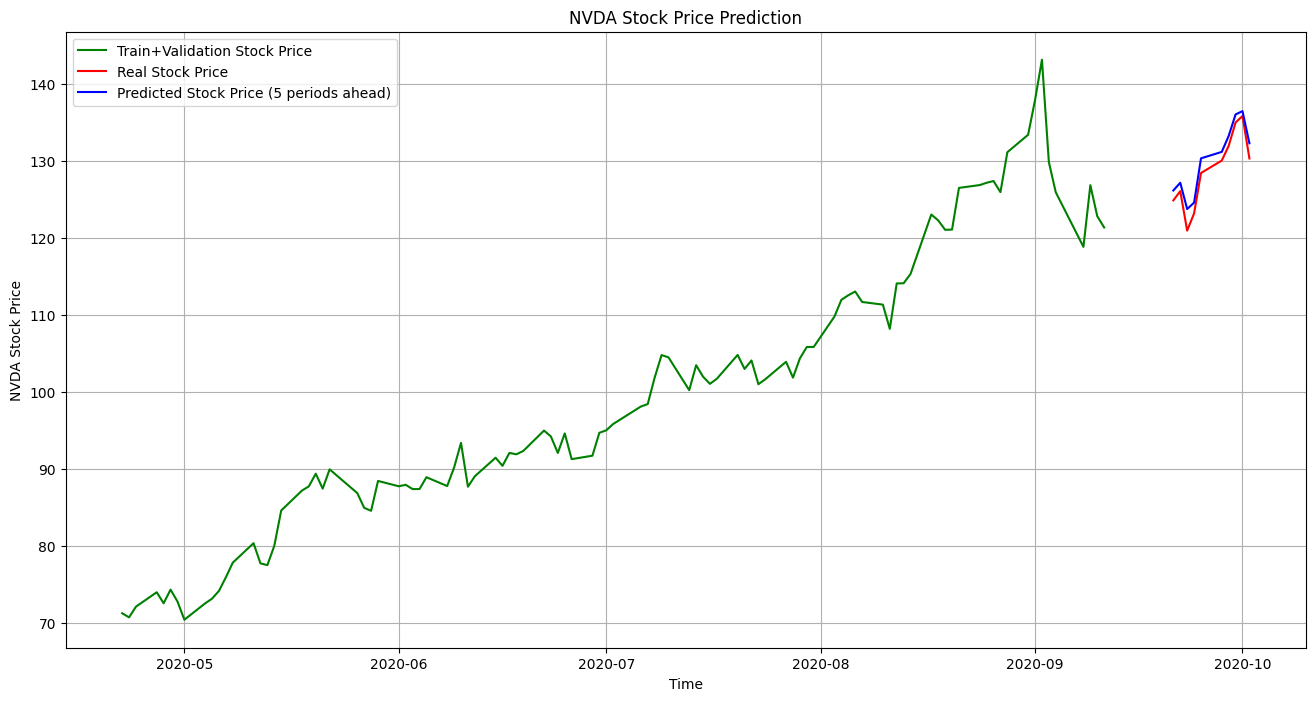

In [188]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
test
plt.plot(train_validation.index[-100:], train_validation.tail(100), color='green', label = 'Train+Validation Stock Price')
plt.plot(test.index[5:PERIODS_TO_PREDICT+5], test[5:PERIODS_TO_PREDICT+5], color = 'red', label = 'Real Stock Price')
plt.plot(test.index[5:PERIODS_TO_PREDICT+5], predictions, color = 'blue', label = 'Predicted Stock Price (5 periods ahead)')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## 1.4) [Code Snippet 5] Binary Decision Tree

In [189]:
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

### 1.4.1) Define dataframes AND perform data cleaning
* define X_train (dataframe), X_test (dataframe), y_train (series), y_test (series)
* replace +-inf. with 0
* fill NaNs with 0 (you can drop it too, but will loose a lot of data in our case
* remove 1-2% outliers (in each dimension, or only in variable to_predict :: we won't use it for a Decision Tree

In [190]:
# Decision Tree doesn't like too large and inf. values
import numpy as np

def remove_infinite_values(X):
    """
    Remove infinite values from the input array.

    Parameters:
    - X: Input array (NumPy array or array-like)

    Returns:
    - Array with infinite values removed
    """
    return X[np.isfinite(X).all(axis=1)]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_infinite_values(X)

In [191]:
# look carefully for 'count' to be close to total values (or you need to replace NaNs/remove NaNs), and min/max doesn't equal to -+inf.
#  it will give you an idea to dig deeper into some features to understand the 'nature' of a problem
pd.set_option('display.max_rows', None)

new_df[NUMERICAL+DUMMIES].describe().T

,count,mean,std,min,25%,50%,75%,max
growth_1d,182660.0,1.000868e+00,2.356674e-02,4.601100e-01,9.906461e-01,1.000473e+00,1.010716e+00,3.018887e+00
growth_3d,182630.0,1.002558e+00,3.947590e-02,4.170567e-01,9.842405e-01,1.002120e+00,1.020217e+00,3.018887e+00
growth_7d,182570.0,1.005875e+00,5.838238e-02,4.065424e-01,9.774801e-01,1.005428e+00,1.033406e+00,3.018887e+00
growth_30d,182225.0,1.025093e+00,1.180397e-01,3.054439e-01,9.622796e-01,1.022171e+00,1.083990e+00,3.993310e+00
growth_90d,181325.0,1.077823e+00,2.209361e-01,1.890111e-01,9.587507e-01,1.061788e+00,1.175049e+00,5.970002e+00
growth_365d,176915.0,1.350498e+00,6.155275e-01,9.783037e-02,1.015438e+00,1.239138e+00,1.527952e+00,9.819906e+00
growth_dax_1d,179673.0,1.000258e+00,1.419365e-02,8.776139e-01,9.937851e-01,1.000761e+00,1.007159e+00,1.114020e+00
growth_dax_3d,179673.0,1.000813e+00,2.417672e-02,8.374862e-01,9.891694e-01,1.002138e+00,1.013879e+00,1.144124e+00
growth_dax_7d,179673.0,1.001993e+00,3.587574e-02,7.318924e-01,9.843275e-01,1.004785e+00,1.021502e+00,1.232460e+00
growth_dax_30d,179673.0,1.008638e+00,7.189179e-02,6.263172e-01,9.727150e-01,1.014873e+00,1.050698e+00,1.288371e+00


In [204]:
# Split the data into training and testing sets based on the split date
features_list = NUMERICAL+DUMMIES
to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)
#all_df = new_df[new_df.split.isin(['train','validation','test'])].copy(deep=True)
all_df = new_df.copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
# need Date and Ticker later when merging predictions to the dataset
X_train = train_df[features_list+[to_predict,'Date','Ticker']]
X_test = test_df[features_list+[to_predict,'Date','Ticker']]
X_all = all_df[features_list+[to_predict,'Date','Ticker']]

print(f'length: X_train {X_train.shape},  X_test {X_test.shape},  X_all {X_all.shape}')


length: X_train (152846, 302),  X_test (29829, 302),  X_all (182675, 302)


In [193]:
# Can't have +-inf values . E.g. ln(volume)=-inf when volume==0 => substitute with 0

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_all.replace([np.inf, -np.inf], np.nan, inplace=True)

# Need to fill NaNs somehow
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)
X_all.fillna(0, inplace=True)

print(f'length: X_train_imputed {X_train.shape},  X_test_imputed {X_test.shape},  X_all_imputed {X_all.shape}')

length: X_train_imputed (152846, 302),  X_test_imputed (29829, 302),  X_all_imputed (182675, 302)


In [194]:
# you may want to remove 1-2% outliers based on percentile ==> not used here in Decision Trees
def remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99):
    """
    Remove outliers from the input array based on percentiles.

    Parameters:
    - X: Input array (NumPy array or array-like)
    - lower_percentile: Lower percentile threshold (float, default=1)
    - upper_percentile: Upper percentile threshold (float, default=99)

    Returns:
    - Array with outliers removed
    """
    lower_bound = np.percentile(X, lower_percentile, axis=0)
    upper_bound = np.percentile(X, upper_percentile, axis=0)
    mask = np.logical_and(np.all(X >= lower_bound, axis=1), np.all(X <= upper_bound, axis=1))
    return X[mask]

# Example usage:
# Assuming X is your input data
# filtered_X = remove_outliers_percentile(X, lower_percentile=1, upper_percentile=99)

In [195]:
X_train_imputed = X_train # we won't use outliers removal to save more data to train: remove_outliers_percentile(X_train)
X_test_imputed = X_test # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_test)
X_all_imputed = X_all # we won't use outliers removal to save more data to test: remove_outliers_percentile(X_all)

In [196]:
# same shape
print(f'length: X_train_imputed {X_train_imputed.shape},  X_test_imputed {X_test_imputed.shape},  X_all_imputed {X_all_imputed.shape}')

length: X_train_imputed (152846, 302),  X_test_imputed (29829, 302),  X_all_imputed (182675, 302)


In [197]:
y_train = X_train_imputed[to_predict]
y_test = X_test_imputed[to_predict]
y_all = X_all_imputed[to_predict]

# remove y_train, y_test, y_all from X_ dataframes
del X_train_imputed[to_predict]
del X_test_imputed[to_predict]
del X_all_imputed[to_predict]

### 1.4.2 Estimation of a Decision Tree model

In [198]:
# INPUTS:
# X_train_imputed : CLEAN dataFrame with only numerical features (train+validation periods)
# X_test_imputed : CLEAN dataFrame with only numerical features (test periods)
# X_all_imputed : CLEAN dataFrame with only numerical features (train+validation+test periods)

# y_train : true values for the train period
# y_test  : true values for the test period
# y_all  : true values for all periods

In [199]:
# estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [200]:
%%time
# drop 2 columns before fitting the tree, but we need those columns later for joins
clf_20, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=20)

CPU times: user 41.2 s, sys: 325 ms, total: 41.5 s
Wall time: 41.7 s


In [218]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_imputed.drop(['Date','Ticker'],axis=1),
                           y=y_train,
                           max_depth=10)

#clf_10, train_columns = fit_decision_tree(X=X_all_imputed.drop(['Date','Ticker'],axis=1),
#                           y=y_all,
#                           max_depth=10)

CPU times: user 26.2 s, sys: 227 ms, total: 26.4 s
Wall time: 26.9 s


In [219]:
# TODO 3: TRAIN only on train dataset, experiment with trees with depth 1..20 --> find the best one on VALID dataset
#       for the "best" tree model: find precision on the TEST set

### 1.4.3 Inference for a Decision Tree

In [220]:
def predict_decision_tree(clf:DecisionTreeClassifier, df_X:pd.DataFrame, y_true: pd.Series):
  # Predict the target variable on the test data
  y_pred = clf.predict(df_X)

  max_depth = clf.tree_.max_depth
  # Print the maximum depth
  print("Maximum depth of the decision tree:", max_depth)

  # Calculate the accuracy/precision of the model
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  print(f'Accuracy ={accuracy}, precision = {precision}')

  # resulting df
  result_df = pd.concat([df_X, y_true, pd.Series(y_pred, index=df_X.index, name='pred_')], axis=1)

  return result_df

In [221]:
pred20 = predict_decision_tree(clf_20, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)

Maximum depth of the decision tree: 20
Accuracy =0.5279761306111502, precision = 0.5730436318671612


In [222]:
# Predictions of a decision tree of depth "20"
pred20.pred_.value_counts()

pred_
1    16983
0    12846
Name: count, dtype: int64

In [225]:
pred10 = predict_decision_tree(clf_10, X_test_imputed.drop(['Date','Ticker'],axis=1), y_test)
#pred10 = predict_decision_tree(clf_10, X_all_imputed.drop(['Date','Ticker'],axis=1), y_all)

Maximum depth of the decision tree: 10
Accuracy =0.5570418049549096, precision = 0.5652784277023866


In [ ]:
pred10.tail()

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,Ticker_SBIN.NS,Ticker_SIE.DE,Ticker_TCS.NS,Ticker_TTE,Ticker_V,ticker_type_EU,ticker_type_INDIA,ticker_type_US,is_positive_growth_5d_future,pred_
5422,0.988994,0.984120,1.021587,1.015755,1.046955,1.793402,0.989726,1.000831,1.010983,0.999750,...,0,0,0,0,0,0,1,0,0,1
5423,1.001447,0.998419,0.996346,0.997589,1.031967,1.790292,0.998011,0.985435,1.001999,0.997982,...,0,0,0,0,0,0,1,0,0,1
5424,0.972302,0.962991,0.969433,0.989441,1.002348,1.738504,1.005873,0.993558,0.992499,1.000784,...,0,0,0,0,0,0,1,0,0,1
5425,0.989571,0.963553,0.952804,0.972509,0.989811,1.732523,1.009644,1.013553,1.004783,1.008886,...,0,0,0,0,0,0,1,0,0,1
5426,0.989735,0.952285,0.938518,0.978882,1.002706,1.737153,1.014021,1.029813,1.028619,1.013796,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
X_test_imputed.join(pred10['pred_']).head()

,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,Ticker_SIE.DE,Ticker_TCS.NS,Ticker_TTE,Ticker_V,ticker_type_EU,ticker_type_INDIA,ticker_type_US,Date,Ticker,pred_
0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.015866,1.032483,1.037417,0.981965,...,0,0,0,0,0,1,0,2022-05-17,LICI.NS,1
1,1.001257,0.000000,0.0,0.0,0.0,0.0,0.987440,0.998562,1.046865,0.964844,...,0,0,0,0,0,1,0,2022-05-18,LICI.NS,1
2,0.959491,0.000000,0.0,0.0,0.0,0.0,0.991044,0.994122,1.025679,0.962420,...,0,0,0,0,0,1,0,2022-05-19,LICI.NS,0
3,0.982518,0.943902,0.0,0.0,0.0,0.0,1.007175,0.985617,1.011084,0.988003,...,0,0,0,0,0,1,0,2022-05-20,LICI.NS,1
4,0.988743,0.932105,0.0,0.0,0.0,0.0,1.013839,1.011968,1.031716,1.006908,...,0,0,0,0,0,1,0,2022-05-23,LICI.NS,1


In [ ]:
# Predictions of a decision tree of depth "10" : many more "positive" predictions
pred10.pred_.value_counts()

pred_
1    25617
0     4212
Name: count, dtype: int64

In [ ]:
# define a new DF with the SAME index (used for joins)
pred20_df = pred20[['pred_']].rename(columns={'pred_': 'pred_tree_clf20'})
pred20_df.head(1)

,pred_tree_clf20
8697,0


In [ ]:
# define a new DF with the SAME index (used for joins)
pred10_df = pred10[['pred_']].rename(columns={'pred_': 'pred_tree_clf10'})
pred10_df.head(1)

,pred_tree_clf10
8697,1


### 1.4.4 Features Importance and Tree Visualisation of top levels (for clf10)

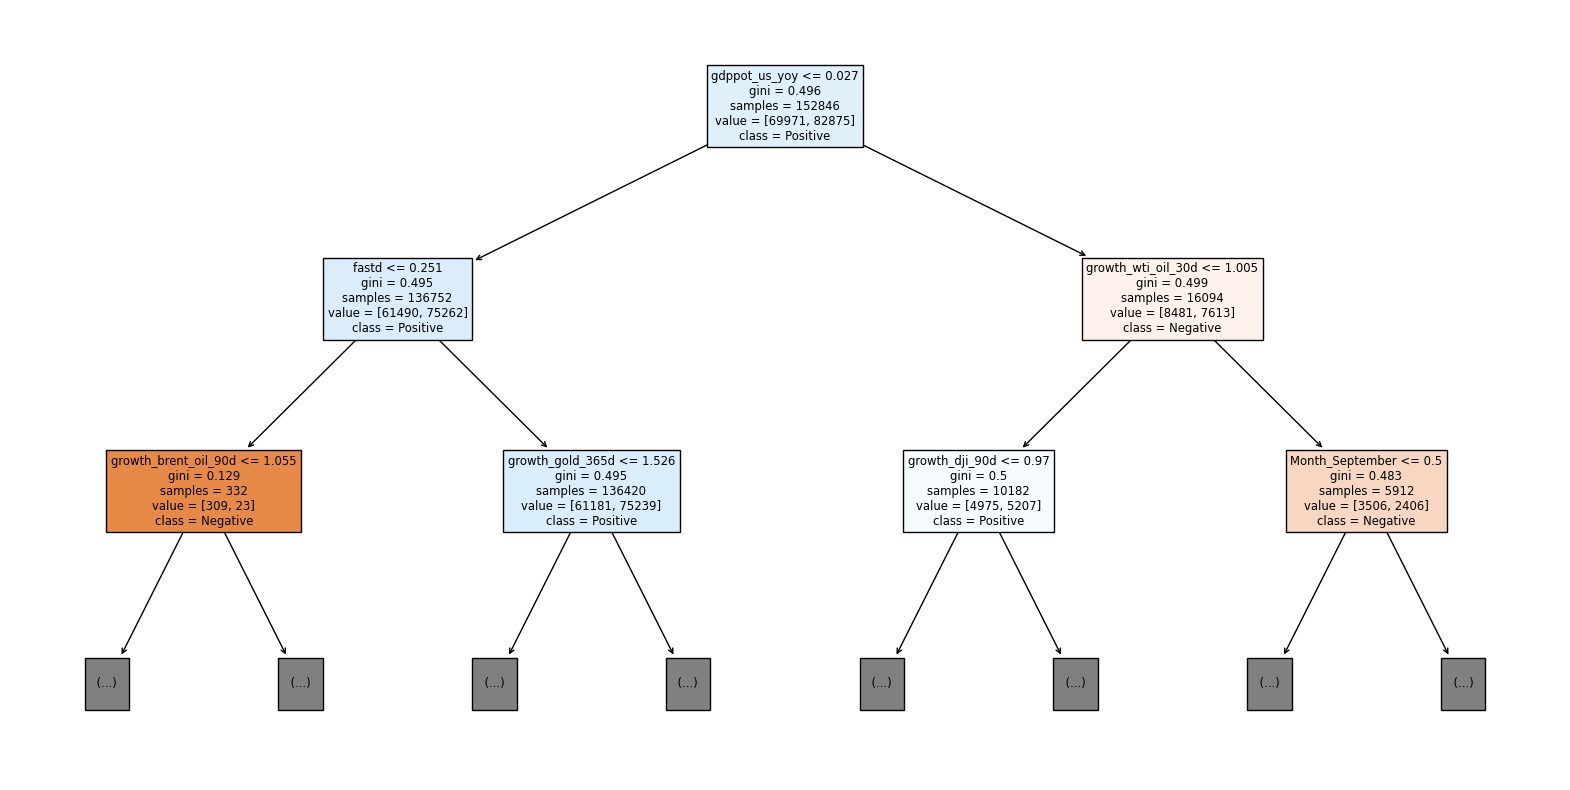

In [ ]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Assuming clf is your trained DecisionTreeClassifier
plt.figure(figsize=(20,10))  # Set the size of the figure
plot_tree(clf_10,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.show()

In [ ]:
# Feautures importance function to predict future returns (based on the classifier)
# get feature importance from 'clf' (classifier) and 'train_columns' (column names)

def get_importances(clf, train_columns):
  # Assuming clf is your trained DecisionTreeClassifier
  feature_importance = clf.feature_importances_

  # Assuming X_train is your training features
  feature_names = train_columns

  # Create a DataFrame to store feature importance
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

  # Sort the DataFrame by importance in descending order
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  # Print or display the feature importance DataFrame
  # print(feature_importance_df)
  return feature_importance_df

In [ ]:
get_importances(clf_10, train_columns).head(10)

,Feature,Importance
41,growth_wti_oil_365d,0.062525
35,growth_gold_365d,0.048194
22,growth_dji_90d,0.037786
183,DGS10,0.037584
178,cpi_core_yoy,0.033569
17,growth_snp500_365d,0.031023
15,growth_snp500_30d,0.030001
9,growth_dax_30d,0.026478
33,growth_gold_30d,0.025946
39,growth_wti_oil_30d,0.025532


In [ ]:
get_importances(clf_20, train_columns).head(10)

,Feature,Importance
35,growth_gold_365d,0.020572
97,natr,0.020197
41,growth_wti_oil_365d,0.017820
39,growth_wti_oil_30d,0.017716
5,growth_365d,0.017484
4,growth_90d,0.016057
93,ad,0.015527
98,ht_dcperiod,0.015513
95,obv,0.015475
178,cpi_core_yoy,0.015367


### 1.4.5 Merge with the original df for predictions (only when predicted on test dataset)

In [ ]:
# current predictions from MANUAL
PREDICTIONS

['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp']

In [ ]:
new_df.head()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,ticker_type_EU,ticker_type_INDIA,ticker_type_US,split,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,is_correct_pred0,is_correct_pred1,is_correct_pred2
3490,58.68750,59.3125,56.00000,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,1,train,0,0,0,1,1,1
3491,56.78125,58.5625,56.12500,56.31250,34.847271,54119000.0,MSFT,2000,January,1,...,0,0,1,train,0,0,0,1,1,1
3492,55.56250,58.1875,54.68750,56.90625,35.214706,64059600.0,MSFT,2000,January,2,...,0,0,1,train,0,1,1,1,0,0
3493,56.09375,56.9375,54.18750,55.00000,34.035072,54976600.0,MSFT,2000,January,3,...,0,0,1,train,0,0,0,1,1,1
3494,54.31250,56.1250,53.65625,55.71875,34.479843,62013600.0,MSFT,2000,January,4,...,0,0,1,train,0,1,1,0,1,1


In [ ]:
# index in df is not unique
np.sort(new_df.groupby(new_df.index).split.count())

array([ 1,  1,  1, ..., 27, 27, 27])

In [ ]:
# it's hard to join with pred10_df - as index is totally different
pred10_df.head()

,pred_tree_clf10
8697,1
8698,1
8699,1
8700,1
8701,1


In [ ]:
# TODO 4: JOIN predictions with the original dataframe (define a new column):
#  so, that there are columns pred_tree_clf10 AND pred_tree_clf20